# Ramachandran Plot from scratch with a PDB file

Now that I've compute the torsion, I can convert protein into a list of torsion angles. Really I want to recreate the ramachandran plot so I'll just plot each one as a point in a density/heatmap plot.

I'll use https://www.rcsb.org/structure/4MS3 for the structure I'll compute on. It is stored locally at [`4ms3.pdb`](./4ms3.pdb).

I simply want the information that has ATOM prefixed. So I'll just grab those rows and throw that information in a pandas data frame

In [211]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("dark_background")

In [212]:
import re

def read_pdb_atoms_lines(filename):
	with open(filename, "r") as f:
		d = f.read()
		atoms = re.findall(r"ATOM\s*\d.*", d) # regex to find ATOM with space after then digit, bit of a hack
		return atoms

read_pdb_atoms_lines("./4ms3.pdb")

['ATOM      1  N   ARG A  50     -58.511   8.223 -23.522  1.00 71.10           N  ',
 'ATOM      2  CA  ARG A  50     -57.205   8.591 -24.072  1.00 70.86           C  ',
 'ATOM      3  C   ARG A  50     -56.771   9.938 -23.501  1.00 74.70           C  ',
 'ATOM      4  O   ARG A  50     -57.044  10.995 -24.084  1.00 74.16           O  ',
 'ATOM      5  CB  ARG A  50     -57.236   8.625 -25.614  1.00 70.40           C  ',
 'ATOM      6  CG  ARG A  50     -56.044   7.971 -26.298  1.00 77.45           C  ',
 'ATOM      7  CD  ARG A  50     -55.941   8.302 -27.785  1.00 80.95           C  ',
 'ATOM      8  NE  ARG A  50     -55.002   7.421 -28.484  1.00 84.03           N  ',
 'ATOM      9  CZ  ARG A  50     -54.420   7.691 -29.651  1.00 93.72           C  ',
 'ATOM     10  NH1 ARG A  50     -54.672   8.834 -30.280  1.00 78.23           N  ',
 'ATOM     11  NH2 ARG A  50     -53.576   6.824 -30.194  1.00 78.49           N  ',
 'ATOM     12  N   ARG A  51     -56.124   9.892 -22.330  1.00 71

In [213]:
def atoms_to_df(atoms: list[str]):
    """Extract Atom Index, Atom, Residue Label, and 3D coordinates"""
    points = []
    idxs = []
    atom_label = []
    residue = []
    residue_id = []
    info = []
    chain = []
    for line in atoms:
        numbers = re.findall(r"\s+[\d|.|-]+", line)
        idx = int(numbers[0])
        x = float(numbers[2])
        y = float(numbers[3])
        z = float(numbers[4])
        idxs.append(idx)
        points.append(np.array([float(x), float(y), float(z)])) 
        residue_id.append(int(numbers[1]))

        strings = re.findall(r"[A-Z]+", line)
        atom_label.append(strings[-1])
        residue.append(strings[2])
        info.append(strings[1])
        chain.append(strings[3])

    return pd.DataFrame({"id": idxs, "chain": chain, "point": points, "atom": atom_label, "residue": residue, "residue_id": residue_id, "info": info})


atoms = read_pdb_atoms_lines("./4ms3.pdb")
df = atoms_to_df(atoms)
df

,id,chain,point,atom,residue,residue_id,info
0,1,A,"[-58.511, 8.223, -23.522]",N,ARG,50,N
1,2,A,"[-57.205, 8.591, -24.072]",C,ARG,50,CA
2,3,A,"[-56.771, 9.938, -23.501]",C,ARG,50,C
3,4,A,"[-57.044, 10.995, -24.084]",O,ARG,50,O
4,5,A,"[-57.236, 8.625, -25.614]",C,ARG,50,CB
...,...,...,...,...,...,...,...
6414,6416,B,"[20.233, 34.309, -18.58]",O,ASP,467,O
6415,6417,B,"[18.648, 36.013, -20.356]",C,ASP,467,CB
6416,6418,B,"[17.609, 36.12, -21.437]",C,ASP,467,CG
6417,6419,B,"[16.563, 35.5, -21.297]",O,ASP,467,OD


Just to check that we have something, plot the chain as a curve

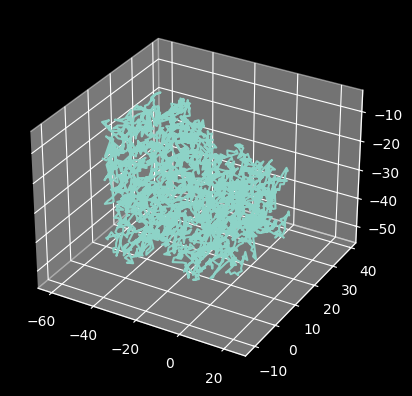

In [214]:
ax = plt.figure().add_subplot(projection='3d')
d = np.vstack(df[df["chain"] == "A"]["point"].array)
ax.plot(d[:, 0], d[:, 1], d[:, 2])

Great works and looks close to https://www.rcsb.org/structure/4MS3

## Compute angles

Now I want to compute $\psi$ and $\phi$ angles and plot the points $(\psi, \phi)$ to create the Ramachandran Plot.

To do that, I need to slide over the atoms and find where we have the four atoms 
- C, N, CA, C as $\phi$
- N, CA, C, N as $\psi$

So I can compute $\psi$ pretty easily be parsing the first 3 atoms of the residue, then the first of the next one as N, C, CA, C.

I can compute $\phi$ starting after by doing the last C, then the first three atoms of the next as N, CA, C.

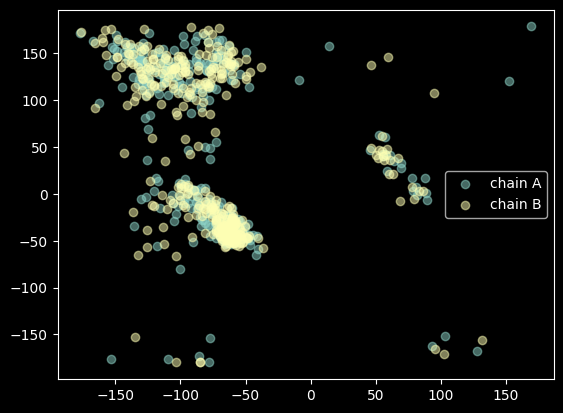

In [219]:
def normalize(v):
    return v / np.linalg.norm(v)

def orthogonal(a, b):
    b = normalize(b)
    orthog = a - b * a.dot(b)
    return normalize(orthog)

def torsion_angle(p1, p2, p3, p4):
    ba = p1-p2 # vector p2 to p1
    bc = p3-p2 # vector p2 to p3
    cd = p4-p3 # vector p4 to p3

    ba_orth = orthogonal(ba, bc) # plane formed by ba and orthogonal to bc
    cd_orth = orthogonal(cd, bc) # plane formed by cd and orthogonal to bc

    angle_deg = np.arccos(ba_orth.dot(cd_orth)) # since both normalized, we can leverage dot product formula to get angle
    sign = np.sign(np.cross(ba_orth, cd_orth).dot(bc)) # either negative angle or positive angle

    return sign*angle_deg

def phi(r1, r2):
	# C, N, CA, C named as variables (A, B, C, D)
	A = r1.iloc[2]["point"] # C
	B = r2.iloc[0]["point"] # N
	C = r2.iloc[1]["point"] # CA
	D = r2.iloc[2]["point"] # C
	return torsion_angle(A, B, C, D)

def psi(r2, r3):
	# N, C, CA, N named as variables (A, B, C, D)
	A = r2.iloc[0]["point"] # N
	B = r2.iloc[1]["point"] # C
	C = r2.iloc[2]["point"] # CA
	D = r3.iloc[0]["point"] # N
	return torsion_angle(A, B, C, D)


def torsions(r1, r2, r3):
	return phi(r1, r2), psi(r2, r3)


def compute_torsions(df):
	residues = list(df.groupby("residue_id"))

	phis = []
	psis = []
	for i in range(0, len(residues)-1):
		(_, r1), (_, r2), (_, r3) = residues[i-1], residues[i], residues[i+1]
		phis.append(phi(r1, r2))
		psis.append(psi(r2, r3))
	return np.array(phis)*180/np.pi, np.array(psis)*180/np.pi

phis, psis = compute_torsions(df[df["chain"] == "A"])
plt.scatter(phis, psis, label="chain A", alpha=0.5)
phis, psis = compute_torsions(df[df["chain"] == "B"])
plt.scatter(phis, psis, label="chain B", alpha=0.5)
plt.legend()

Heatmap of both chains combined

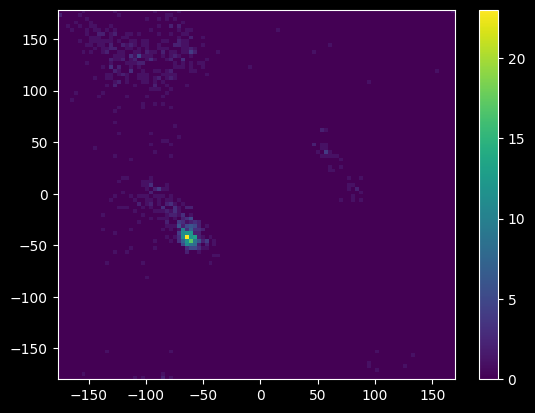

In [218]:
a_phis, a_psis = compute_torsions(df[df["chain"] == "A"])
b_phis, b_psis = compute_torsions(df[df["chain"] == "B"])
phis = np.hstack((a_phis, b_phis))
psis = np.hstack((a_psis, b_psis))
density, x_bins, y_bins = np.histogram2d(phis, psis, 100)
plt.pcolormesh(x_bins.T, y_bins.T, density.T)
plt.colorbar()